# Random Forest

## Motivation

Below is an Ox a cow from a weight judging competition from 1906 year. 787 participants guessed the weight of the cow. The median error of individual guesses was around 3.1%, while overall median of the guesses was only 0.7%. This is an example of the wisdom of the crowd principle used for <b>ensemble</b> training. 

### Ox - a cow

```{image} ml_rf1.jpg
:alt: img-recognition
:class: bg-primary mb-1
:width: 500px
:align: center
```

### Predictions of the crowd

```{image} ml_rf2.jpg
:alt: img-recognition
:class: bg-primary mb-1
:width: 500px
:align: center
```

Mathematically this approach comes from bias-variance decomposition principle, where an error of the estimator is happen to come from bias of the estimator and its variance. Assuming, we have a lot of unbiased simple estimators, by combining them we can reduce the variance of the overall prediction, thus reducing the error. 

Mathematically, it can also be seen from the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) in statistics. Where, the more samples we have, the less the variance term would be. And it will decrease as $ \frac{1}{N} $.

For this method to work, simple predictors must not be highly correlated. Otherwise, variance decrease would be much smaller. 

## Random forest

Random Forest uses this idea to train multiple decision trees and then combine them together into an ensemble. Each decision tree is trained using some random noise that comes from the way they are trained. They are two approaches <b>bagging</b> and <b>attribute sampling</b> that allows to train weakly correlated individual trees, which we will discuss below. 

## Bagging

Idea of bagging or <b>b</b>ootstrap <b>agg</b>regat<b>ing</b> comes from statistical bootstrap method, where training data for the individual decision tree is sampled from the original training data with replacement, so that the final size of data is still equal to the original size. The sampled subset is typically of the size 67% of the original data. To fill the remaining size, replacement is used. Let's consider how bagging splits the training data on example of a dataset of size 6. 

| Tree id | Sample 1 | Sample 2 | Sample 3 | Sample 4 | Sample 5 | Sample 6 |
|:-------:|----------|----------|----------|----------|----------|----------|
| Original data | 1 | 1 | 1 | 1 | 1 | 1 |
| 1st Tree | 1 | 2 | 0 | 2 | 0 | 1 |
| 2nd Tree | 0 | 1 | 1 | 0 | 3 | 1 |
| 3rd Tree | 2 | 0 | 1 | 2 | 1 | 0 |

Each row represents whether the sample is included for the training of the tree and number of resamplments of the data point, so that in total sum of resamplements is 6. This kind of method already influences into making trees less correlated.

## Attribute sampling

Attribute sampling means that at each split of the decision trees instead of looking at the whole set of available features, we only look at the subset of features which are chosen randomly. For regression task usually one third of total number of available features are considered, while for classification usually square root of total number of features are considered. This method is similar to a droupout technique in neural networks where we drop a proportion of available features, which helps to prevent overfitting. But, for training random forests it usually is used for making individual trees different from one each other, so that their ensemble will be stronger than each possibly individual tree could be. 


### Attribute sampling

```{image} ml_rf3.jpg
:alt: img-recognition
:class: bg-primary mb-1
:width: 500px
:align: center
```

Consider an example above, with four features in total, but only three of them are randomly picked (light yellow color) during each split to decide the best split (red color for the best split). 

In `sklearn` package, we can pass the attribute sampling parameter through `max_features` parameter into both `RandomForestClassifier` and `RandomForestRegressor` clases. It accepts integers to define number explicitly, floats as a ratio from total number of features, and using keywords like `sqrt` for a square root from total number.

## Synthetic example of benefits from ensemble 

Let's create a syntethic example of classifying points being inside circle of radius 0.8.

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x1, x2 = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
x1, x2 = x1.reshape(300 * 300), x2.reshape(300 * 300)

ys = []
for a, b in zip(x1, x2):
    ys.append(a ** 2 + b ** 2 <= 0.8)
    
df = pd.DataFrame({
    'x1': x1,
    'x2': x2,
    'y': ys
})

def plot(inside, plt, title):
    plt.plot(df[~inside].x1, df[~inside].x2, '.', label = 'outside')
    plt.plot(df[inside].x1, df[inside].x2, '.', label = 'inside')
    plt.set_title(title)
    plt.legend()

Train random forest classifier.

In [84]:
from sklearn.ensemble import RandomForestClassifier

X = df[['x1', 'x2']].values
clf = RandomForestClassifier(max_depth = 7, n_estimators = 10, random_state=0)
clf.fit(X, df.y)
y_pred = clf.predict(X)

Show predictions and true labels. We can see that we have good classifications using random forest, which can be further improved by increasing `max_depth` parameter.

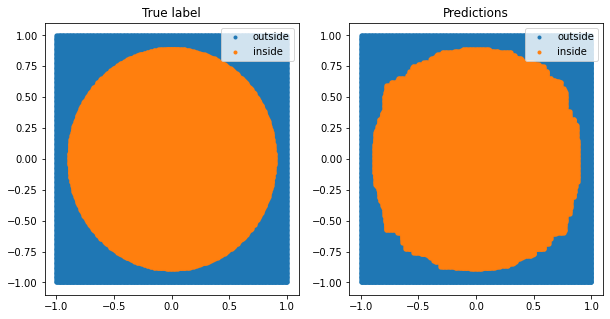

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot(df.y, axs[0], 'True label')
plot(y_pred, axs[1], 'Predictions')
plt.show()

Now let's look into individual predictions. We can see that their quality is much worse than the random forest ensemble. But, on average they are better than each individual tree.

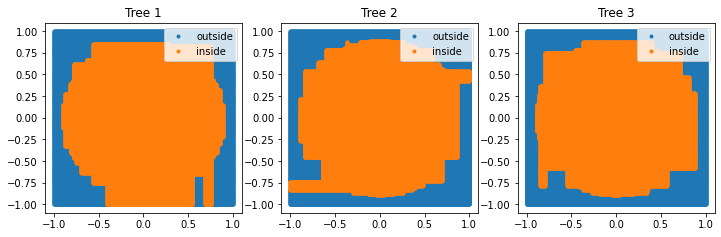

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
for i in range(3):
    y_pred = clf.estimators_[i].predict(X)
    plot(y_pred > 0.5, axs[i], 'Tree %d' % (i + 1))
plt.show()

## Does random forest overfit?

There is a general property of a random forest that when we increase number of decision trees in the ensemble the accuracy almost never reduces on the validation dataset. Which means adding more decision trees cannot lead random forest to overfit. Let's test it on the `California Housing dataset`.

First let's look into the general training procedure of the `RandomForestRegressor` class.

In [114]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the California Housing dataset as an example
data = fetch_california_housing()
X = data.data
y = data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor with 100 trees (estimators)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest Regressor on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")

Mean Squared Error: 0.26
R-squared (R2) Score: 0.81


Now define a function which would return r2 score from a regressor model. And train random forest models with different `n_estimators` parameter, which corresponds to number of decision trees in the ensemble.

In [115]:
def get_r2(rf_model):
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return r2_score(y_test, y_pred)


nestimators = []
r2s = []
for i in range(1, 102, 10):
    rf_model = RandomForestRegressor(n_estimators=i, random_state=42)
    r2 = get_r2(rf_model)
    nestimators.append(i)
    r2s.append(r2)

From the plot below we can see that our accuracy will keep improving, but never reduces after adding additional trees. Which means this parameter never leads to overfitting, but can only slow down the training. Since, it is more expensive to train many trees. Therefore, middle point of accuracy and fast training should be chosen.  

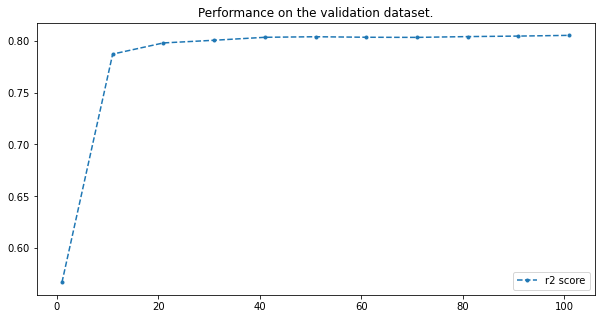

In [116]:
plt.figure(figsize=(10, 5))
plt.plot(nestimators, r2s, '.--', label='r2 score')
plt.title('Performance on the validation dataset.')
plt.legend(loc='lower right')
plt.show()

## Feature importance

`SkLearn` provides a very convenient way to understand which feature is considered important for making a prediction in random forests. It provides calculated importances based on the [impurity reduction](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_). We know that each node in the decision tree performs the split of the data based on some impurity criterion, mean square error for regression tasks and gini/entropy for a classification task. Each node using feature values performs the split that reduces impurity of the data. And normalized total reduction of impurity brought by a feature is calculated in `feature_importances_` attribute.

Let's get back to our `California Housing dataset`, and see which features are more important. The higher the value, the higher is importance, which can be used for further feature selection.

<AxesSubplot:ylabel='feature_names'>

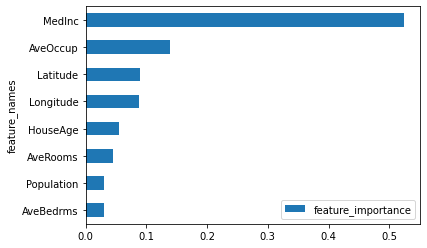

In [133]:
importance_df = pd.DataFrame({
    'feature_importance': rf_regressor.feature_importances_,
    'feature_names': data.feature_names
})

importance_df.sort_values('feature_importance', inplace=True)
importance_df.set_index('feature_names', inplace=True)

importance_df.plot(kind='barh')